In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D


In [2]:
customer_df = pd.read_csv('../data/customers.csv', parse_dates=["signup_date"])
print(customer_df.head(10))

  customer_id signup_date  true_lifetime_days
0      C00000  2025-08-22                 204
1      C00001  2025-03-07                 365
2      C00002  2025-08-18                  48
3      C00003  2025-09-22                  84
4      C00004  2025-05-28                 113
5      C00005  2025-11-12                 120
6      C00006  2025-08-22                 117
7      C00007  2025-08-03                 321
8      C00008  2025-05-02                 209
9      C00009  2025-01-06                 172


In [3]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         3000 non-null   object        
 1   signup_date         3000 non-null   datetime64[ns]
 2   true_lifetime_days  3000 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 70.4+ KB


In [4]:
transaction_df = pd.read_csv('../data/transactions.csv', parse_dates=["transaction_date"])
print(transaction_df.head(10))

  customer_id transaction_date  amount
0      C00000       2025-09-10  195.78
1      C00000       2025-09-12   50.87
2      C00000       2025-10-01  133.25
3      C00000       2025-10-16   37.44
4      C00000       2025-10-18  101.95
5      C00000       2025-10-28  195.22
6      C00000       2025-11-23  206.80
7      C00000       2025-11-27   79.74
8      C00000       2025-12-09   85.42
9      C00000       2025-12-27   47.99


In [6]:
transaction_df["transaction_date"].max()

Timestamp('2025-12-31 00:00:00')

## 1. Customer Value Foundations
Yêu cầu:
● Tính RFM

● Phân nhóm khách hàng:
○ High-value / At-risk
○ New / Loyal / Hibernating

● Phân tích mối liên hệ:
○ RFM vs churn

Mục tiêu: RFM có thể cung cấp phân tích ban đầu nhưng không đủ

In [23]:
snapshot_date = transaction_df["transaction_date"].max() + pd.Timedelta(days=1)
print("Snapshot Date:", snapshot_date)

rfm = (transaction_df.groupby('customer_id')
        .agg({"transaction_date": lambda x: (snapshot_date - x.max()).days,
            "customer_id": "count", 
            "amount": "sum"
        })
        .rename(columns={
            "customer_id": "frequency",
            "transaction_date": "recency",
            "amount": "monetary"
        })
        .reset_index())

rfm.head()                 

Snapshot Date: 2026-01-01 00:00:00


,customer_id,recency,frequency,monetary
0,C00000,1,12,1222.85
1,C00001,12,19,1228.46
2,C00002,97,11,910.64
3,C00003,44,4,114.71
4,C00004,109,19,2018.94


In [ ]:
# Fit transform data before K-Means
df_scaled = rfm[["recency", "frequency", "monetary"]].copy().rename(columns=lambda column_name: column_name + "_scaled")
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df_scaled)

# Create dataframe
rfm_scaled_df = pd.DataFrame(
    rfm_scaled,
    columns=[f"{c}_scaled" for c in df_scaled.columns]
)
print(rfm_scaled_df.head(10))

   recency_scaled_scaled  frequency_scaled_scaled  monetary_scaled_scaled
0              -0.958971                -0.242153                0.233769
1              -0.838010                 0.166359                0.238421
2               0.096691                -0.300511               -0.025108
3              -0.486122                -0.709023               -0.685074
4               0.228648                 0.166359                0.893867
5              -0.936978                -0.475588               -0.606791
6              -0.563098                -0.767381               -0.708921
7               0.052705                -0.650664               -0.295427
8              -0.288186                -0.125435               -0.143249
9               1.185342                 0.108000                0.627155


Text(0, 0.5, 'Within Cluster Sum of Squares')

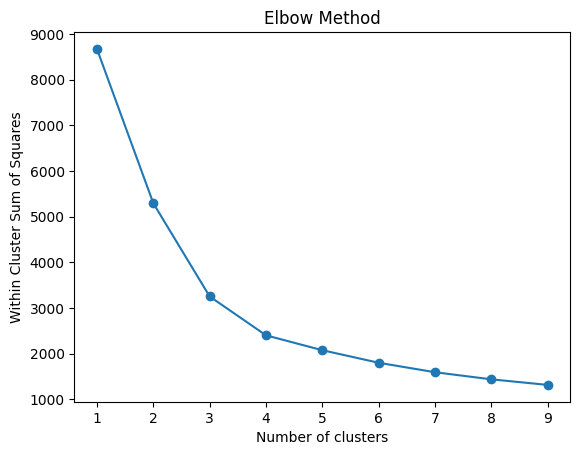

In [36]:
inner_variance = []
# Range of expected number of clusters
range_of_clusters = range(1,10) 
for cluster in range_of_clusters:
    kmeans_model = KMeans(n_clusters=cluster)
    kmeans_model.fit(rfm_scaled_df)  
    inner_variance.append(kmeans_model.inertia_) 

# Visualization (Elbow Method)
plt.plot(range_of_clusters, inner_variance, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Within Cluster Sum of Squares")


In [95]:
# K-Means Modelling
kmeans = KMeans(init="k-means++", random_state=10, n_clusters=5)
rfm["segment"] = kmeans.fit_predict(rfm_scaled)
rfm.head()

,customer_id,recency,frequency,monetary,segment
0,C00000,1,12,1222.85,4
1,C00001,12,19,1228.46,4
2,C00002,97,11,910.64,2
3,C00003,44,4,114.71,4
4,C00004,109,19,2018.94,0


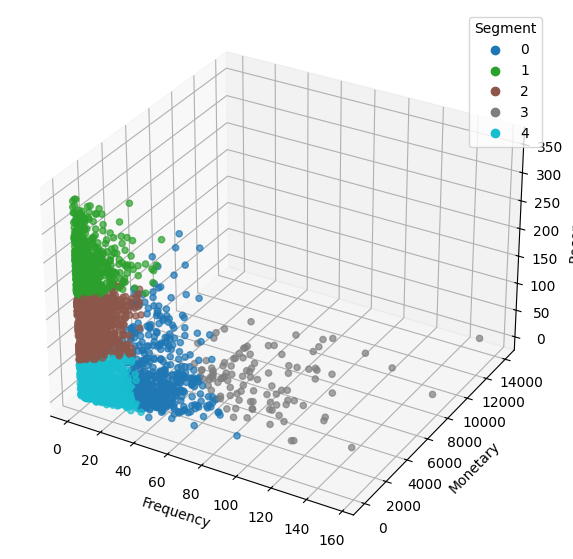

In [96]:
# If segment is categorical, convert to numeric codes
segments = rfm["segment"].astype("category")
segment_codes = segments.cat.codes

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm["frequency"],
    rfm["monetary"],
    rfm["recency"],
    c=segment_codes,
    cmap="tab10",
    alpha=0.7
)

ax.set_xlabel("Frequency")
ax.set_ylabel("Monetary")
ax.set_zlabel("Recency")

# Create legend
legend_labels = segments.cat.categories
handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', 
               color=scatter.cmap(scatter.norm(i)))
    for i in range(len(legend_labels))
]
ax.legend(handles, legend_labels, title="Segment")

plt.show()

In [98]:
segment_profile

,recency,frequency,monetary
segment,,,
3,11.896226,74.490566,5119.913491
0,35.527831,33.145873,2034.733129
4,22.476627,11.252979,561.199716
2,130.256677,8.611276,446.450504
1,246.018000,6.916000,410.318420


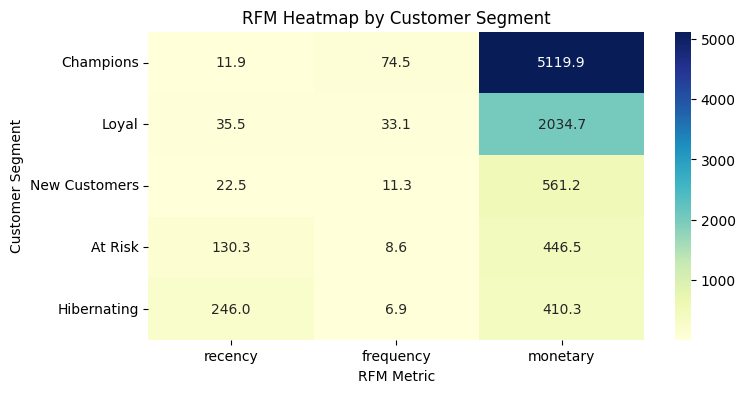

In [102]:
segment_profile = (rfm.groupby('segment')[["recency", "frequency", "monetary"]]
                   .mean()
                   .sort_values(["monetary", "frequency"], ascending=False))

plt.figure(figsize=(8, 4))
ax = sns.heatmap(
    segment_profile,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu"
)

# Custom segment names (order must match the heatmap index order)
segment_labels = [
    "Champions",
    "Loyal",
    "New Customers",
    "At Risk",
    "Hibernating"
]

ax.set_yticklabels(segment_labels, rotation=0)

ax.set_ylabel("Customer Segment")
ax.set_xlabel("RFM Metric")
ax.set_title("RFM Heatmap by Customer Segment")

plt.title("RFM Heatmap by Customer Segment")
plt.show()